In [1]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
pd.set_option('display.max_rows', None)

## load main data

In [2]:
data_df = pd.read_csv(r'../Data/Unprocessed/expr_joint.csv')
data_df.shape

(247, 30108)

In [3]:
data_df.iloc[:2,:5]

,Unnamed: 0,sp|P55011|S12A2_HUMAN,sp|O60341|KDM1A_HUMAN,sp|O00570|SOX1_HUMAN,sp|P48431|SOX2_HUMAN
0,ACH-000007,2.784515,-0.625217,-1.009702,-0.686197
1,ACH-000008,-0.018971,-0.076679,-0.023220,1.799710


In [4]:
ranked_fts_df = pd.read_csv(r'../Data/Unprocessed/rank_ordered_joint_features.csv').iloc[:, 1:]
print(ranked_fts_df.shape)
ranked_fts_df.head(2)

(19638, 3)


,Feature Name,SVM coefficient,Modality
0,RGS2 (5997),0.008402,Transcriptomics
1,MME (4311),0.008304,Transcriptomics


In [5]:
with open(r'../Data/Unprocessed/protein_cols.txt', "r") as file: # edit
    protein_cols = [line.strip() for line in file]
with open(r'../Data/Unprocessed/rna_cols.txt', "r") as file: # edit
    rna_cols = [line.strip() for line in file]
len(protein_cols), len(rna_cols)

(10969, 19138)

## process feature names

In [6]:
with open(r'../Data/Unprocessed/uniprot_mapper.json') as json_file: # edit
    uid_mapper = json.load(json_file)
    
# manually mapped some that failed to map using uniprot ID
manual_map = {'Q9TNN7': 'HLA-C',
                'P16189': 'HLA-A',
                'P30456': 'HLA-A',
                'P30443': 'HLA-A',
                'P05534': 'HLA-A',
                'P18462': 'HLA-A',
                'P01892': 'HLA-A',
                'P13746': 'HLA-A',
                'P01891': 'HLA-A',
                'P30483': 'HLA-B',
                'P30484': 'HLA-B',
                'P03989': 'HLA-B',
                'P30460': 'HLA-B',
                'P30461': 'HLA-B',
                'Q95365': 'HLA-B',
                'P16188': 'HLA-A',
                'Q95604': 'HLA-C',
                'Q07000': 'HLA-C',
                'P30499': 'HLA-C',
                'P30501': 'HLA-C',
                'P30504': 'HLA-C',
                'Q95IE3': 'HLA-DRB1',
                'P04229': 'HLA-DRB1',
                'P20039': 'HLA-DRB1',
                'P13760': 'HLA-DRB1',
                'Q5Y7A7': 'HLA-DRB1',
                'Q9GIY3': 'HLA-DRB1',
                'Q9TQE0': 'HLA-DRB1',
                'Q30134': 'HLA-DRB1'}

In [7]:
# protein_names = [] # edit
# test = [] # edit
protein_names_dict = {} # edit
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
#     protein_names.append(gene_name) # edit
    protein_names_dict[protein_id] = gene_name
    
    rna_names_dict = {rna_id:rna_id.split(' (')[0] for rna_id in rna_cols}

In [8]:
rna_names_dict = {rna_id:rna_id.split(' (')[0] for rna_id in rna_cols}

In [9]:
assert list(ranked_fts_df['Modality'].unique())==['Transcriptomics', 'Proteomics']
ranked_fts_df['Gene Name'] = np.where(ranked_fts_df['Modality']=='Transcriptomics',
                                 ranked_fts_df['Feature Name'].map(rna_names_dict), 
                                 ranked_fts_df['Feature Name'].map(protein_names_dict))
assert sum(ranked_fts_df['Gene Name'].isna())==0

In [10]:
# number of proteins
len(ranked_fts_df[ranked_fts_df['Modality']=='Proteomics']['Feature Name'].to_list())

500

In [11]:
# number of proteins with rna feature
ranked_fts_subdf = ranked_fts_df.groupby('Gene Name').filter(lambda g: 
                                                      {'Transcriptomics', 'Proteomics'}.issubset(set(g['Modality'])))
print(ranked_fts_subdf.shape[0])
prots_in_rankedfts_w_rna = ranked_fts_subdf[ranked_fts_subdf['Modality']=='Proteomics']['Feature Name'].to_list()
len(prots_in_rankedfts_w_rna)

987


494

In [12]:
ranked_fts_subdf[ranked_fts_subdf['Modality']=='Proteomics']['Gene Name'].nunique()

493

In [13]:
# (2*493) + 1, bc 1 gene has 2 prots
ranked_fts_prot_subdf = ranked_fts_subdf[ranked_fts_subdf['Modality']=='Proteomics']
ranked_fts_prot_subdf[ranked_fts_prot_subdf.duplicated(subset=['Modality', 'Gene Name'], keep=False)]

,Feature Name,SVM coefficient,Modality,Gene Name
3347,sp|P07951|TPM2_HUMAN,-0.001350,Proteomics,TPM2
4711,sp|P07951-2|TPM2_HUMAN,0.001099,Proteomics,TPM2


In [14]:
ranked_fts_df[ranked_fts_df['Gene Name']=='TPM2']
# below: since transcript is not in top_n rank until after both proteins, 
    # only encountered scenarios includes both pairs being in non-overlapping or overlapping set (feeding into that mean)

,Feature Name,SVM coefficient,Modality,Gene Name
3347,sp|P07951|TPM2_HUMAN,-0.001350,Proteomics,TPM2
4711,sp|P07951-2|TPM2_HUMAN,0.001099,Proteomics,TPM2
14888,TPM2 (7169),-0.000193,Transcriptomics,TPM2


## calculate same gene correlations for protein genes

In [15]:
def calc_corr(values_df, ft1, ft2, corr_type):
    if corr_type=='pearson':
        r, p = scipy.stats.pearsonr(values_df.loc[:,ft1].values, values_df.loc[:,ft2].values)
    elif corr_type=='spearman':
        r, p = scipy.stats.spearmanr(values_df.loc[:,ft1].values, values_df.loc[:,ft2].values)
    else: raise('choose pearson or spearman')
    return r,p

### pearson

In [16]:
pearson_corr_df = pd.DataFrame(columns=['prot_ft', 'rna_ft', 'r', 'p'])
for prot_ft in tqdm(prots_in_rankedfts_w_rna):
    rna_df = ranked_fts_df[(ranked_fts_df['Gene Name']==protein_names_dict[prot_ft]) & 
                           (ranked_fts_df['Modality']=='Transcriptomics')]
    assert rna_df.shape[0]==1
    rna_ft = rna_df['Feature Name'].values[0]
    r, p = calc_corr(values_df=data_df, ft1=prot_ft, ft2=rna_ft, corr_type='pearson')
    new_row = pd.DataFrame({'prot_ft': [prot_ft],  'rna_ft':[rna_ft], 'r': [r], 'p': [p]})
    pearson_corr_df = pd.concat([pearson_corr_df, new_row], ignore_index=True)
pearson_corr_df.shape

100%|███████████████████████████████████████████████████████████████████████████████| 494/494 [00:03<00:00, 160.24it/s]


(494, 4)

In [17]:
pearson_corr_df['Gene Name'] = pearson_corr_df['rna_ft'].map(rna_names_dict)

In [18]:
pearson_corr_df.head()

,prot_ft,rna_ft,r,p,Gene Name
0,sp|P04792|HSPB1_HUMAN,HSPB1 (3315),0.716928,2.912173e-40,HSPB1
1,sp|P27487|DPP4_HUMAN,DPP4 (1803),0.870572,2.027148e-77,DPP4
2,sp|P00750|TPA_HUMAN,PLAT (5327),0.778066,2.217055e-51,PLAT
3,sp|Q29983|MICA_HUMAN,MICA (100507436),0.420408,5.352116e-12,MICA
4,sp|O94875-11|SRBS2_HUMAN,SORBS2 (8470),0.776549,4.609672e-51,SORBS2


In [ ]:
# pearson_corr_df.to_csv(r'..\Data\Processed\SameGenePearsonCorr.csv', index=False)

### spearman

In [20]:
spearman_corr_df = pd.DataFrame(columns=['prot_ft', 'rna_ft', 'r', 'p'])
for prot_ft in tqdm(prots_in_rankedfts_w_rna):
    rna_df = ranked_fts_df[(ranked_fts_df['Gene Name']==protein_names_dict[prot_ft]) & 
                           (ranked_fts_df['Modality']=='Transcriptomics')]
    assert rna_df.shape[0]==1
    rna_ft = rna_df['Feature Name'].values[0]
    r, p = calc_corr(values_df=data_df, ft1=prot_ft, ft2=rna_ft, corr_type='spearman')
    new_row = pd.DataFrame({'prot_ft': [prot_ft],  'rna_ft':[rna_ft], 'r': [r], 'p': [p]})
    spearman_corr_df = pd.concat([spearman_corr_df, new_row], ignore_index=True)
spearman_corr_df.shape

100%|███████████████████████████████████████████████████████████████████████████████| 494/494 [00:03<00:00, 164.56it/s]


(494, 4)

In [21]:
spearman_corr_df['Gene Name'] = spearman_corr_df['rna_ft'].map(rna_names_dict)

In [22]:
spearman_corr_df.head()

,prot_ft,rna_ft,r,p,Gene Name
0,sp|P04792|HSPB1_HUMAN,HSPB1 (3315),0.722974,3.155940e-41,HSPB1
1,sp|P27487|DPP4_HUMAN,DPP4 (1803),0.744633,6.605948e-45,DPP4
2,sp|P00750|TPA_HUMAN,PLAT (5327),0.732360,8.890638e-43,PLAT
3,sp|Q29983|MICA_HUMAN,MICA (100507436),0.413640,1.255344e-11,MICA
4,sp|O94875-11|SRBS2_HUMAN,SORBS2 (8470),0.798185,7.547026e-56,SORBS2


In [ ]:
# spearman_corr_df.to_csv(r'..\Data\Processed\SameGeneSpearmanCorr.csv', index=False)

### partial - see R code

## calculate mean correlations split by overlapping vs not

In [24]:
def calc_overlapping_vs_not_mean_correlations(top_n, cor_df, cor_col):
    top_n_fts_df = ranked_fts_df.iloc[:top_n, :]
    
    rna_genes = set(top_n_fts_df[top_n_fts_df['Modality'] == 'Transcriptomics']['Gene Name'])
    protein_genes = set(top_n_fts_df[top_n_fts_df['Modality'] == 'Proteomics']['Gene Name'])
    
    common_genes = protein_genes.intersection(rna_genes)
    only_prot_genes = protein_genes.difference(rna_genes)
    
    numb_overlapping_genes = len(common_genes)
    numb_nonoverlapping_genes = len(only_prot_genes)
    
    overlapping_cor_df = cor_df[cor_df['Gene Name'].isin(common_genes)]
    nonoverlapping_cor_df = cor_df[cor_df['Gene Name'].isin(only_prot_genes)]
    
    if overlapping_cor_df.shape[0]>0:
        mean_overlapping_cor = overlapping_cor_df[cor_col].mean()
    else: 
        mean_overlapping_cor = np.nan
    if nonoverlapping_cor_df.shape[0]>0:
        mean_nonoverlapping_cor = nonoverlapping_cor_df[cor_col].mean()
    else: 
        mean_nonoverlapping_cor = np.nan
    return top_n, numb_overlapping_genes, mean_overlapping_cor, numb_nonoverlapping_genes, mean_nonoverlapping_cor

In [25]:
ranked_split_mean_pearson_corr_df = pd.DataFrame(columns=['Feature Rank', 
                                                          'Number of Overlapping Genes', 
                                                          'Overlapping Mean Pearson Correlation', 
                                                          'Number of Non-overlapping Genes',
                                                          'Non-overlapping Mean Pearson Correlation'])

for rank in tqdm(range(1, ranked_fts_df.shape[0]+1)):
    top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor = calc_overlapping_vs_not_mean_correlations(
                                                                        top_n=rank, cor_df=pearson_corr_df, cor_col='r') 
    ranked_split_mean_pearson_corr_df = pd.concat([ranked_split_mean_pearson_corr_df, 
                                                   pd.DataFrame(
                                                       [[top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor]], 
                                                        columns=ranked_split_mean_pearson_corr_df.columns)], 
                                                   ignore_index=True)
ranked_split_mean_pearson_corr_df.shape

100%|███████████████████████████████████████████████████████████████████████████| 19638/19638 [02:49<00:00, 115.80it/s]


(19638, 5)

In [26]:
# ranked_split_mean_pearson_corr_df.to_csv(r'..\Data\Processed\SameGeneSplitMeanPearsonCorr.csv', index=False)

In [27]:
ranked_split_mean_spearman_corr_df = pd.DataFrame(columns=['Feature Rank', 
                                                          'Number of Overlapping Genes', 
                                                          'Overlapping Mean Spearman Correlation', 
                                                          'Number of Non-overlapping Genes',
                                                          'Non-overlapping Mean Spearman Correlation'])

for rank in tqdm(range(1, ranked_fts_df.shape[0]+1)):
    top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor = calc_overlapping_vs_not_mean_correlations(
                                                                        top_n=rank, cor_df=spearman_corr_df, cor_col='r') 
    ranked_split_mean_spearman_corr_df = pd.concat([ranked_split_mean_spearman_corr_df, 
                                                   pd.DataFrame(
                                                       [[top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor]], 
                                                        columns=ranked_split_mean_spearman_corr_df.columns)], 
                                                   ignore_index=True)
ranked_split_mean_spearman_corr_df.shape

100%|███████████████████████████████████████████████████████████████████████████| 19638/19638 [02:53<00:00, 113.29it/s]


(19638, 5)

In [29]:
# ranked_split_mean_spearman_corr_df.to_csv(r'..\Data\Processed\SameGeneSplitMeanSpearmanCorr.csv', index=False)

### visualize

#### pearson

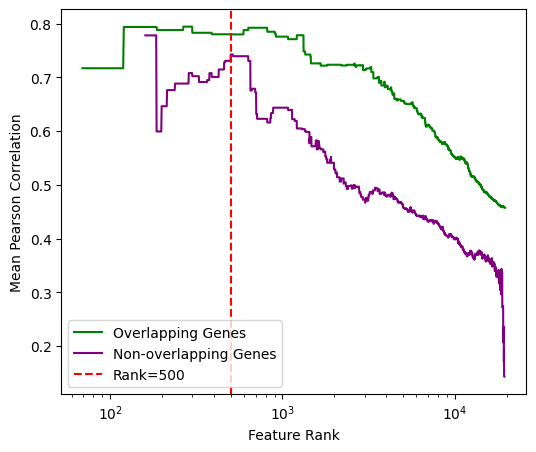

In [32]:
fig, ax = plt.subplots(figsize = (6,5))
sns.lineplot(data = ranked_split_mean_pearson_corr_df, x = 'Feature Rank', y = 'Overlapping Mean Pearson Correlation',
             color='green', label='Overlapping Genes')
sns.lineplot(data = ranked_split_mean_pearson_corr_df, x = 'Feature Rank', y = 'Non-overlapping Mean Pearson Correlation', 
             color='purple', label='Non-overlapping Genes')
ax.axvline(x=500, color='red', linestyle='--', label='Rank=500')
ax.set_ylabel('Mean Pearson Correlation')
ax.set_xscale('log')
ax.legend()
# fig.savefig('..\Figures\SameGeneSplitMeanPearsonCorr_lines.png', dpi=300, bbox_inches="tight");

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))
sns.lineplot(data = ranked_split_mean_pearson_corr_df, x = 'Feature Rank', y = 'Number of Overlapping Genes',
             color='green', label='Overlapping Genes')
sns.lineplot(data = ranked_split_mean_pearson_corr_df, x = 'Feature Rank', y = 'Number of Non-overlapping Genes', 
             color='purple', label='Non-overlapping Genes')
ax.axvline(x=500, color='red', linestyle='--', label='Rank=500')
ax.set_ylabel('Number of Genes')
ax.set_xscale('log')
ax.legend();

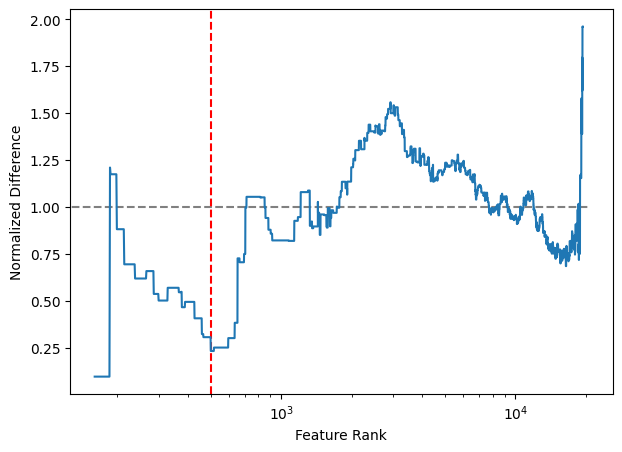

In [33]:
ranked_split_mean_pearson_corr_df['Difference'] = ranked_split_mean_pearson_corr_df[
    'Overlapping Mean Pearson Correlation'] - ranked_split_mean_pearson_corr_df['Non-overlapping Mean Pearson Correlation']
ranked_split_mean_pearson_corr_df['Normalized Difference'
                ] = ranked_split_mean_pearson_corr_df.Difference / ranked_split_mean_pearson_corr_df['Difference'].mean()

fig, ax = plt.subplots(figsize = (7,5))
sns.lineplot(data = ranked_split_mean_pearson_corr_df, x = 'Feature Rank', y = 'Normalized Difference')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines(1, xmin = xmin, xmax = xmax, color = 'gray', linestyle = '--')
ax.vlines(500, ymin = ymin, ymax = ymax, color = 'red', linestyle = '--')
ax.set_xscale('log')
ax.set_ylim(ymin, ymax)
# fig.savefig('..\Figures\SameGeneNormalizedDiffPearsonCorr_lines.png', dpi=300, bbox_inches="tight");

#### spearman

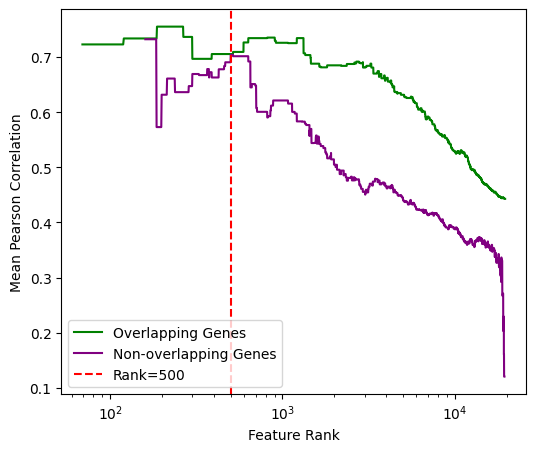

In [35]:
fig, ax = plt.subplots(figsize = (6,5))
sns.lineplot(data = ranked_split_mean_spearman_corr_df, x = 'Feature Rank', y = 'Overlapping Mean Spearman Correlation',
             color='green', label='Overlapping Genes')
sns.lineplot(data = ranked_split_mean_spearman_corr_df, x = 'Feature Rank', y = 'Non-overlapping Mean Spearman Correlation', 
             color='purple', label='Non-overlapping Genes')
ax.axvline(x=500, color='red', linestyle='--', label='Rank=500')
ax.set_ylabel('Mean Pearson Correlation')
ax.set_xscale('log')
ax.legend()
# fig.savefig('..\Figures\SameGeneSplitMeanSpearmanCorr_lines.png', dpi=300, bbox_inches="tight");

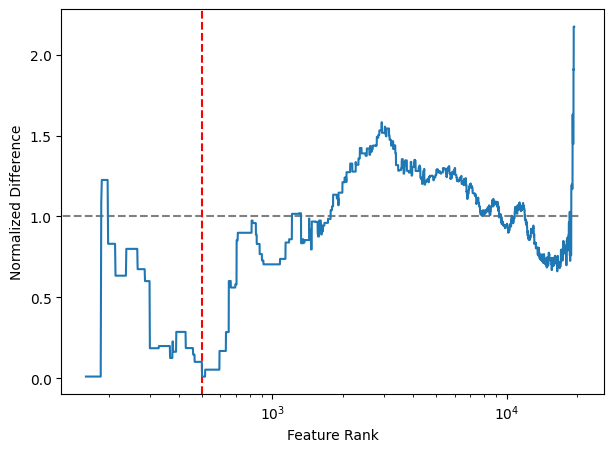

In [36]:
ranked_split_mean_spearman_corr_df['Difference'] = ranked_split_mean_spearman_corr_df[
    'Overlapping Mean Spearman Correlation'] - ranked_split_mean_spearman_corr_df['Non-overlapping Mean Spearman Correlation']
ranked_split_mean_spearman_corr_df['Normalized Difference'
                ] = ranked_split_mean_spearman_corr_df.Difference / ranked_split_mean_spearman_corr_df['Difference'].mean()

fig, ax = plt.subplots(figsize = (7,5))
sns.lineplot(data = ranked_split_mean_spearman_corr_df, x = 'Feature Rank', y = 'Normalized Difference')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines(1, xmin = xmin, xmax = xmax, color = 'gray', linestyle = '--')
ax.vlines(500, ymin = ymin, ymax = ymax, color = 'red', linestyle = '--')
ax.set_xscale('log')
ax.set_ylim(ymin, ymax)
# fig.savefig('..\Figures\SameGeneNormalizedDiffSpearmanCorr_lines.png', dpi=300, bbox_inches="tight");

#### partial

In [31]:
# set to 0 if not sig & leave as is

## calculate mean correlations without splitting

In [37]:
def calc_overall_mean_correlations(top_n, cor_df, cor_col):
    top_n_fts_df = ranked_fts_df.iloc[:top_n, :]
    
    protein_fts = set(top_n_fts_df[top_n_fts_df['Modality'] == 'Proteomics']['Feature Name'])
    
    sub_cor_df = cor_df[cor_df['prot_ft'].isin(protein_fts)]
                        
    if sub_cor_df.shape[0]>0:
        mean_cor = sub_cor_df[cor_col].mean()
    else: 
        mean_cor = np.nan
    
    return top_n,  mean_cor

In [38]:
ranked_overall_mean_pearson_corr_df = pd.DataFrame(columns=['Feature Rank', 'Overall Mean Pearson Correlation'])

for rank in tqdm(range(1, ranked_fts_df.shape[0]+1)):
    top_n, mean_cor = calc_overall_mean_correlations(top_n=rank, cor_df=pearson_corr_df, cor_col='r') 
    ranked_overall_mean_pearson_corr_df = pd.concat([ranked_overall_mean_pearson_corr_df, 
                                                     pd.DataFrame([[top_n, mean_cor]], 
                                                        columns=ranked_overall_mean_pearson_corr_df.columns)], 
                                                   ignore_index=True)
ranked_overall_mean_pearson_corr_df.shape

100%|███████████████████████████████████████████████████████████████████████████| 19638/19638 [00:57<00:00, 343.67it/s]


(19638, 2)

In [39]:
# ranked_overall_mean_pearson_corr_df.to_csv(r'..\Data\Processed\SameGeneOverallMeanPearsonCorr.csv', index=False)

In [40]:
ranked_overall_mean_spearman_corr_df = pd.DataFrame(columns=['Feature Rank', 'Overall Mean Spearman Correlation'])

for rank in tqdm(range(1, ranked_fts_df.shape[0]+1)):
    top_n, mean_cor = calc_overall_mean_correlations(top_n=rank, cor_df=spearman_corr_df, cor_col='r') 
    ranked_overall_mean_spearman_corr_df = pd.concat([ranked_overall_mean_spearman_corr_df, 
                                                     pd.DataFrame([[top_n, mean_cor]], 
                                                        columns=ranked_overall_mean_spearman_corr_df.columns)], 
                                                   ignore_index=True)
ranked_overall_mean_spearman_corr_df.shape

100%|███████████████████████████████████████████████████████████████████████████| 19638/19638 [00:55<00:00, 356.53it/s]


(19638, 2)

In [41]:
# ranked_overall_mean_spearman_corr_df.to_csv(r'..\Data\Processed\SameGeneOverallMeanSpearmanCorr.csv', index=False)

### visualize

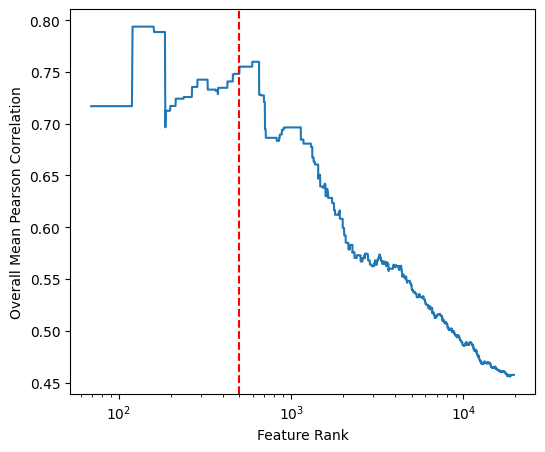

In [42]:
fig, ax = plt.subplots(figsize = (6,5))
sns.lineplot(data = ranked_overall_mean_pearson_corr_df, x = 'Feature Rank', y = 'Overall Mean Pearson Correlation')
ax.axvline(x=500, color='red', linestyle='--', label='Rank=500')
ax.set_ylabel('Overall Mean Pearson Correlation')
ax.set_xscale('log')
#ax.legend()
# fig.savefig('..\Figures\SameGeneOverallMeanPearsonCorr_lines.png', dpi=300, bbox_inches="tight");

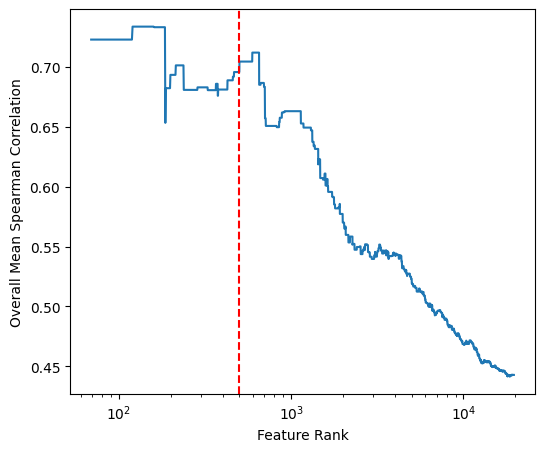

In [43]:
fig, ax = plt.subplots(figsize = (6,5))
sns.lineplot(data = ranked_overall_mean_spearman_corr_df, x = 'Feature Rank', y = 'Overall Mean Spearman Correlation')
ax.axvline(x=500, color='red', linestyle='--', label='Rank=500')
ax.set_ylabel('Overall Mean Spearman Correlation')
ax.set_xscale('log')
#ax.legend()
# fig.savefig('..\Figures\SameGeneOverallMeanSpearmanCorr_lines.png', dpi=300, bbox_inches="tight");